In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, execute, circuit, extensions
import matplotlib.pyplot as plt
import math
import numpy as np
from functools import reduce
import pandas as pd
from sklearn.model_selection import train_test_split
from qiskit.visualization import plot_bloch_multivector
from qiskit.quantum_info import Statevector
from datetime import datetime
from qiskit.aqua.components.optimizers import COBYLA, ADAM, AQGD, NFT

# Constants

In [2]:
#CONSTANTSSSSSS

#data
n_data_points = 8
data_dimensionality = 2


#generator constants
circuit_depth = 1
circuit_width = math.ceil(math.log2(data_dimensionality)) + 1 + math.ceil(math.log2(n_data_points))


# Data prep

In [3]:
df = pd.read_csv("bezdekIris.data", header=None)
#give classes numbers
df[4] = [0 if p == "Iris-setosa" else 1 if p == "Iris-virginica" else 2 for p in df[4]]
#reduce to just 2 classes
df = df[df[4] != 2]

In [4]:
train, test = train_test_split(df, test_size=0.36)
data = train[[0,1]].to_numpy()
labels = train[4].to_numpy()

n_label0s = n_data_points / 2
n_label1s = n_data_points / 2

label0s = []
label1s = []

for i in range(len(labels)):
    if labels[i] == 0 and n_label0s > 0:
        n_label0s -= 1
        label0s.append(i)
        
    if labels[i] == 1 and n_label1s > 0:
        n_label1s -= 1
        label1s.append(i)
        
    if n_label0s < 1 and n_label1s < 1:
        break

idx = label0s + label1s
        
data = data[idx]
labels = labels[idx]

# Helper functions

In [5]:
def normalize(l):
    normalization_factor = math.sqrt(sum([i ** 2 for i in l]))
    return [i / normalization_factor for i in l]

def init_gate(init_states, label=None, size=None):
    if not size:
        size = math.ceil(math.log2(len(init_states)))
    state_vector = normalize(init_states) + [0] * ((2 ** size) - len(init_states))
    #I know this is way ugly, but it's the easiest way to actualy turn initialize() into a gate
    return extensions.Initialize(state_vector).gates_to_uncompute().inverse().to_gate(label=label if label else None)

In [6]:
def x_indices(i, bits):
    indices = []
    for j in range(bits):
        bit = (i >> j) & 1
        if not bit:
            indices.append(j)
    return indices

In [7]:
def destructive_swap(n):
    q = QuantumRegister(n * 2)
    circuit = QuantumCircuit(q)
    
    for i in range(n):
        circuit.cx(i, n+i)
        circuit.h(i)
    return circuit.to_gate(label="destructive_swap")

def interpret_des_swap(counts):
    successes = 0
    for k in counts:
        #success if and of measurement has even parity, that's what the paper said
        success = reduce(lambda b, p: (p == ('1', '1')) ^ b , zip(list(k[:len(k)//2]), list(k[len(k)//2:])), True)
        if success:
            successes += counts[k]
    if sum(counts.values()) == 0:
        return 0
    return  2 * (successes / sum(counts.values())) - 1

In [8]:
def swap(n):
    q = QuantumRegister(n * 2 + 1)
    circuit = QuantumCircuit(q)
    circuit.h(q[0])
    
    for i in range(0, n):
        circuit.cswap(0, 1 + i, 1 + n+i)
    circuit.h(q[0])
#     print(circuit)
    return circuit.to_gate(label="swap")
# swap(2)

In [9]:
def seriessum(n):
    n_sum = 0
    for i in range(n):
        n_sum += i
    return n_sum

# Oracle meuk

In [10]:
def construct_oracle(data, labels):
    # gate = init_gate([0,2,10], "psi_0")
    data_bits = math.ceil(math.log2(data.shape[1]))
    counting_bits = math.ceil(math.log2(data.shape[0]))
    q = QuantumRegister(data_bits + counting_bits + 1)
    qc = QuantumCircuit(q)

#     data = [[x,x*2,x**2] for x in range(1, 16)]
    qc.h(q[data_bits + 1:])
    for i in range(len(data)):
        x_i = [data_bits + 1 + x_i for x_i in x_indices(i,counting_bits)]
        if len(x_i) > 0:
            qc.x(x_i)
        gate = init_gate(data[i], f"psi_{i}", data_bits).control(counting_bits)
        qc.append(gate, q[data_bits + 1:] + q[:data_bits])
        if labels[i] == 1:
            x_gate = circuit.library.XGate().control(counting_bits)
            qc.append(x_gate, q[data_bits + 1:] + [q[data_bits]])

        if len(x_i) > 0:
            qc.x(x_i)
    return qc, data_bits, counting_bits

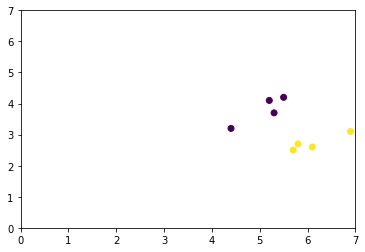

In [11]:
plt.scatter(x=data[:, 0], y=data[:, 1], c=labels)
plt.xlim([0,7])
plt.ylim([0,7])

plt.show()

# Classifier

In [12]:
def construct_destructive_classifier(oracle, data_bits, oracle_label="oracle"):
    oracle_gate = oracle.to_gate(label=oracle_label)

    q = QuantumRegister(data_bits + oracle.num_qubits)
    c = ClassicalRegister(data_bits * 2 + 1)
    qc = QuantumCircuit(q, c)
    
    qc.append(oracle, q[data_bits:])
    qc.append(destructive_swap(data_bits), q[:data_bits] + q[data_bits:data_bits+data_bits])
    for i in range(data_bits * 2 + 1):
        qc.measure(i,i)
    return qc

In [13]:
def classify_destructive(inp, classifier):
    num_qubits = classifier.num_qubits

    data_size = math.ceil(math.log2(len(inp)))

    num_cbits = data_size * 2 + 1


    q = QuantumRegister(num_qubits)
    c = ClassicalRegister(num_cbits)
    qc = QuantumCircuit(q, c)

    # inp_gate = init_gate([1,2,0,4])
    inp_gate = init_gate(inp, label="input", size=data_size)


    qc.append(inp_gate, q[:data_size])
    qc = qc.compose(classifier)
    backend = Aer.get_backend('qasm_simulator')
    job = execute(backend=backend, experiments=qc, shots=10001)
    result = job.result()

    counts = result.get_counts()
    counts_0 = {key[1:]:value for key, value in counts.items() if key[0] == '0'}
    counts_1 = {key[1:]:value for key, value in counts.items() if key[0] == '1'}

    return (interpret_des_swap(counts_0), interpret_des_swap(counts_1))

In [34]:
def eval_classifier(data, labels, test, oracle, log=False):
    data_bits = math.ceil(math.log2(data.shape[1]))
    classifier = construct_destructive_classifier(oracle, data_bits)

    label_names = [0,1]
    correct = 0
    count = 0
    
    classification_results = []
    
    for index, row in test.iterrows():
        label = row[4]
        results = classify_destructive(row[[0,1]].tolist(), classifier)
        cor = False
        if results[0] > results[1]:
            class_estimate = 0
        else:
            class_estimate = 1
        
        if results[0] > results[1] and label == labels[0]:
            correct += 1
            cor = True
        elif results[0] < results[1] and label == labels[1]:
            correct += 1
            cor = True
        count += 1
        classification_results.append((class_estimate, results))
        if log:
            print(f"features:({row[0]}, {row[1]}), label:{label}, result:{label_names[0]}:{results[0]}, {label_names[1]}:{results[1]}, {'correct' if cor else 'incorrect'}, accuracy:{correct / count}")

    return correct / len(test), classification_results
    

# Generator

In [15]:
# n_features gets boiled down to amount of qubits necessary for it to work TODO: Change n_labels to do the same
def build_variational_circuit(depth, generator_width, params=None, measurement=False):
    # TODO: Add y and z rotations
    n_qubits = generator_width
    
    def seriessum(n):
        n_sum = 0
        for i in range(n):
            n_sum += i
        return n_sum
    
    n_rot_qubits_per_layer = n_qubits * 2
    n_qubits_per_layer = n_rot_qubits_per_layer + seriessum(n_qubits)
    n_entangle_qubits_per_layer = seriessum(n_qubits)
    
#     print(params)
    
    if params is None:
        params = np.random.rand(depth * (n_rot_qubits_per_layer + n_entangle_qubits_per_layer)) * math.pi
    
#     print(params)
    
#     print(len(params))
    
    q = QuantumRegister(n_qubits)
    if measurement:
        c = ClassicalRegister(n_qubits)
        qc = QuantumCircuit(q, c)
    else:
        qc = QuantumCircuit(q)
        
    
    # Dynamically add rx rotation and rxx entanglement gates
    for i in range(depth):
        for j in range(n_qubits):
#             print(i * depth, j)
#             print(i * n_qubits_per_layer, j, (i * n_qubits_per_layer) + j)
            qc.rx(params[i * n_qubits_per_layer + j*2], j)
            qc.rz(params[i * n_qubits_per_layer + j*2 + 1], j)
        next_param = 0
        for j in range(n_qubits):
#             print(i * n_qubits_per_layer, j, (i * n_qubits_per_layer) + j)
            for k in range(n_qubits):
                if j == k or j < k:
                    continue
#                 print(i * n_qubits_per_layer + n_rot_qubits_per_layer + next_param)
#                 print(i * n_rot_qubits_per_layer + j + next_param + n_rot_qubits_per_layer)
                qc.rxx(params[i * n_qubits_per_layer + n_rot_qubits_per_layer + next_param], j, k)
                next_param += 1
        
        if measurement:
            qc.barrier()
    
    if measurement:
        for i in range(n_qubits):
            qc.measure(i, i)
            
    return qc
      
# build_variational_circuit(8, 2, 1, measurement=True).draw()

In [16]:
def generate_params(circuit_depth, circuit_width):

    n_qubits = circuit_width

    def seriessum(n):
        n_sum = 0
        for i in range(n):
            n_sum += i
        return n_sum

    n_rot_qubits_per_layer = n_qubits * 2
    n_qubits_per_layer = n_qubits * 2 + seriessum(n_qubits)
    n_entangle_qubits_per_layer = seriessum(n_qubits)

    generated_params = np.random.rand(circuit_depth * (n_rot_qubits_per_layer + n_entangle_qubits_per_layer)) * math.pi

    return generated_params

In [17]:
eval_classifier(data, labels, test, build_variational_circuit(circuit_depth, circuit_width), log=False)

0.5555555555555556

# Gan

In [18]:
def build_gan_stack(depth, width, orcale, params=None):
    n_data_qubits = width - 1
    
    generator = build_variational_circuit(depth, width, params=params)
    
    oracle_gate = oracle.to_gate(label="oracle")
    generator_gate = generator.to_gate(label="generator")
    
    n_qubits = oracle.num_qubits + generator.num_qubits + 1
    
    q = QuantumRegister(n_qubits)
    c = ClassicalRegister(1)
    qc = QuantumCircuit(q, c)
    
    swap_ancilla = q[:1]
    generator_qubits = q[1:generator.num_qubits + 1]
    generator_output_qubits = q[1:1 + n_data_qubits + 1]
    oracle_qubits = q[generator.num_qubits + 1:]
    oracle_output_qubits = q[generator.num_qubits + 1: generator.num_qubits + 1 + n_data_qubits]
    oracle_label_qubits = q[generator.num_qubits + 1 + n_data_qubits:generator.num_qubits + 1 + n_data_qubits + 1]

    oracle_counting_qubits = q[generator.num_qubits + 1 + n_data_qubits + 1:]
    
    qc.append(generator_gate, generator_qubits)
    qc.append(oracle_gate, oracle_qubits)
    
    swap_test_gate = swap(n_data_qubits + 1)
    swap_test_qubits = swap_ancilla + generator_output_qubits + oracle_output_qubits + oracle_label_qubits
#     print(len(generator_output_qubits), len(oracle_output_qubits), len(oracle_label_qubits))
    
    qc.append(swap_test_gate, swap_test_qubits)
    
    qc.measure(0, 0)
    
    return qc

oracle, data_bits, counting_bits = construct_oracle(data, labels)
build_gan_stack(circuit_depth, data_bits + 1, oracle).draw()

┌───────┐┌─┐
q1101_0: ──────────────┤0      ├┤M├
         ┌────────────┐│       │└╥┘
q1101_1: ┤0           ├┤1      ├─╫─
         │  generator ││       │ ║ 
q1101_2: ┤1           ├┤2 swap ├─╫─
         └┬─────────┬─┘│       │ ║ 
q1101_3: ─┤0        ├──┤3      ├─╫─
          │         │  │       │ ║ 
q1101_4: ─┤1        ├──┤4      ├─╫─
          │         │  └───────┘ ║ 
q1101_5: ─┤2 oracle ├────────────╫─
          │         │            ║ 
q1101_6: ─┤3        ├────────────╫─
          │         │            ║ 
q1101_7: ─┤4        ├────────────╫─
          └─────────┘            ║ 
  c37: 1/════════════════════════╩═
                                 0

In [19]:
def build_gan_stack_with_count(depth, width, oracle, params=None):
#     oracle, n_data_qubits, n_counting_qubits = construct_oracle(data, labels)
#     width = oracle.num_qubits
    generator = build_variational_circuit(depth, width, params=params)
    
    oracle_gate = oracle.to_gate(label="oracle")
    generator_gate = generator.to_gate(label="generator")
    
    n_qubits = oracle.num_qubits + generator.num_qubits + 1
    
    q = QuantumRegister(n_qubits)
    c = ClassicalRegister(1)
    qc = QuantumCircuit(q, c)
    
    swap_ancilla = q[:1]
    generator_qubits = q[1:generator.num_qubits + 1]
#     generator_output_qubits = q[1:1 + width]
    oracle_qubits = q[generator.num_qubits + 1:]
#     oracle_output_qubits = q[generator.num_qubits + 1: generator.num_qubits + width]
#     oracle_label_qubits = q[generator.num_qubits + 1 + width - 1:generator.num_qubits + width + 1]

#     oracle_counting_qubits = q[generator.num_qubits + 1 + n_data_qubits + 1:]
    
    qc.append(generator_gate, generator_qubits)
    qc.append(oracle_gate, oracle_qubits)
    swap_test_gate = swap(oracle.num_qubits)
    swap_test_qubits = swap_ancilla + generator_qubits + oracle_qubits
#     print(len(generator_output_qubits), len(oracle_output_qubits), len(oracle_label_qubits))
    
    qc.append(swap_test_gate, swap_test_qubits)
    
    qc.measure(0, 0)
    
    return qc

build_gan_stack_with_count(circuit_depth, circuit_width, construct_oracle(data, labels)[0]).draw()

┌────────┐┌─┐
 q1121_0: ──────────────┤0       ├┤M├
          ┌────────────┐│        │└╥┘
 q1121_1: ┤0           ├┤1       ├─╫─
          │            ││        │ ║ 
 q1121_2: ┤1           ├┤2       ├─╫─
          │            ││        │ ║ 
 q1121_3: ┤2 generator ├┤3       ├─╫─
          │            ││        │ ║ 
 q1121_4: ┤3           ├┤4       ├─╫─
          │            ││        │ ║ 
 q1121_5: ┤4           ├┤5  swap ├─╫─
          └┬─────────┬─┘│        │ ║ 
 q1121_6: ─┤0        ├──┤6       ├─╫─
           │         │  │        │ ║ 
 q1121_7: ─┤1        ├──┤7       ├─╫─
           │         │  │        │ ║ 
 q1121_8: ─┤2 oracle ├──┤8       ├─╫─
           │         │  │        │ ║ 
 q1121_9: ─┤3        ├──┤9       ├─╫─
           │         │  │        │ ║ 
q1121_10: ─┤4        ├──┤10      ├─╫─
           └─────────┘  └────────┘ ║ 
   c38: 1/═════════════════════════╩═
                                   0

In [20]:
def train_gan(gan_builder, data, labels, iterations):
    intermediate_results = []

    n_qubits = circuit_width

    n_rot_qubits_per_layer = n_qubits * 2
    n_qubits_per_layer = n_qubits * 2 + seriessum(n_qubits)
    n_entangle_qubits_per_layer = seriessum(n_qubits)

    param_size = circuit_depth * (n_rot_qubits_per_layer + n_entangle_qubits_per_layer)
    total_runs = 0
    
    oracle,_,_ = construct_oracle(data, labels)
    init_params = generate_params(circuit_depth, circuit_width)

    
    best_result = -np.Inf
    best_params = init_params
    
    

    def objective_function(params):
        nonlocal total_runs
        nonlocal best_result
        nonlocal best_params
        params.shape = (params.size // param_size, param_size)
        results = []
        tracked_inter_res = False

        total_runs += params.shape[0]
        for param_set in params:
            # construct circuit with given params
            qc = gan_builder(circuit_depth, circuit_width, oracle, param_set)

            backend = Aer.get_backend('qasm_simulator')
            job = execute(backend=backend, experiments=qc, shots=100000)
            counts = job.result().get_counts()

            result = 2 * counts['0'] / sum(counts.values()) - 1
            if not tracked_inter_res:
                print("counts: ", counts)
                print("Intermediate:", result)
                print("total runs: ", total_runs)
                intermediate_results.append(-result)
                tracked_inter_res = True
                
            if result > best_result:
                best_result = result
                best_params = param_set
            
            results.append(-result)

        return results


    print("Initial parameters:", init_params)
    # objective_function(params)

    # optimizer = COBYLA(maxiter=100)
    optimizer = AQGD(maxiter=iterations)

    ret = optimizer.optimize(num_vars=len(init_params), objective_function=objective_function, initial_point=init_params)

    print("Supposed optimal parameters:", ret)
    plt.plot(intermediate_results)
    plt.show()
    return best_result, best_params


# evaluation

In [35]:
#accuracy with real data classifier
accuracy_oracle, results_oracle = eval_classifier(data, labels, test, construct_oracle(data, labels)[0], log=True)

features:(6.4, 2.8), label:1.0, result:0:0.9552179128348661, 1:1.0, incorrect, accuracy:0.0
features:(6.0, 3.0), label:1.0, result:0:0.9732267732267732, 1:0.9979983987189751, incorrect, accuracy:0.0
features:(5.9, 3.0), label:1.0, result:0:0.9711861061772251, 1:0.9979732468585327, incorrect, accuracy:0.0
features:(6.7, 2.5), label:1.0, result:0:0.9192200557103065, 1:0.9943718592964823, incorrect, accuracy:0.0
features:(5.0, 3.5), label:0.0, result:0:0.997983870967742, 1:0.9654830390795477, correct, accuracy:0.2
features:(4.3, 3.0), label:0.0, result:0:0.9983942191890807, 1:0.9697150826857939, correct, accuracy:0.3333333333333333
features:(5.4, 3.7), label:0.0, result:0:0.9987949387427195, 1:0.9693349263241737, correct, accuracy:0.42857142857142855
features:(6.5, 3.2), label:1.0, result:0:0.9674698795180723, 1:0.9988050189205337, incorrect, accuracy:0.375
features:(5.6, 2.8), label:1.0, result:0:0.9622110552763818, 1:0.998408276959809, incorrect, accuracy:0.3333333333333333
features:(7.

Initial parameters: [2.9644906  1.01441421 0.28890839 0.61147841 3.00388968 0.87562524
 0.42878699 2.50236423 2.63875732 1.54884097 2.32945808 0.27226098
 0.54674584 2.62282151 2.47046981 0.03901723 2.93716566 1.22521434
 1.48127337 0.93912356]


/home/leo/anaconda3/lib/python3.7/site-packages/qiskit/aqua/components/optimizers/optimizer.py:50: DeprecationWarning: The package qiskit.aqua.components.optimizers is deprecated. It was moved/refactored to qiskit.algorithms.optimizers (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  'qiskit.algorithms.optimizers', 'qiskit-terra')


counts:  {'1': 47878, '0': 52122}
Intermediate: 0.04244000000000003
total runs:  41
counts:  {'1': 47547, '0': 52453}
Intermediate: 0.049060000000000104
total runs:  82
counts:  {'1': 46813, '0': 53187}
Intermediate: 0.06373999999999991
total runs:  123
counts:  {'1': 45768, '0': 54232}
Intermediate: 0.08464000000000005
total runs:  164
counts:  {'0': 55134, '1': 44866}
Intermediate: 0.1026800000000001
total runs:  205
counts:  {'0': 55897, '1': 44103}
Intermediate: 0.11793999999999993
total runs:  246
counts:  {'1': 42918, '0': 57082}
Intermediate: 0.14164
total runs:  287
counts:  {'1': 41685, '0': 58315}
Intermediate: 0.1662999999999999
total runs:  328
counts:  {'1': 39721, '0': 60279}
Intermediate: 0.2055800000000001
total runs:  369
counts:  {'1': 38376, '0': 61624}
Intermediate: 0.23248000000000002
total runs:  410
counts:  {'0': 63668, '1': 36332}
Intermediate: 0.27336000000000005
total runs:  451
counts:  {'1': 34223, '0': 65777}
Intermediate: 0.31553999999999993
total runs:  

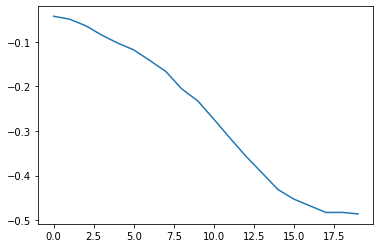

In [22]:
similarity, best_params = train_gan(build_gan_stack_with_count, data, labels, 20)

In [26]:
generator = build_variational_circuit(circuit_depth, circuit_width, params = best_params)

In [37]:
accuracy_generator, results_generator = eval_classifier(data, labels, test, generator, log=True)

features:(6.4, 2.8), label:1.0, result:0:0.9207630227439472, 1:0.9817320703653587, incorrect, accuracy:0.0
features:(6.0, 3.0), label:1.0, result:0:0.9455197132616489, 1:0.9910591471801926, incorrect, accuracy:0.0
features:(5.9, 3.0), label:1.0, result:0:0.9400943396226416, 1:0.9895851414684951, incorrect, accuracy:0.0
features:(6.7, 2.5), label:1.0, result:0:0.8935814841326652, 1:0.9762478485370052, incorrect, accuracy:0.0
features:(5.0, 3.5), label:0.0, result:0:0.9922273500121448, 1:0.9714479945615229, correct, accuracy:0.2
features:(4.3, 3.0), label:0.0, result:0:0.987053464397027, 1:0.9739279588336192, correct, accuracy:0.3333333333333333
features:(5.4, 3.7), label:0.0, result:0:0.9923499880468563, 1:0.9755929872808524, correct, accuracy:0.42857142857142855
features:(6.5, 3.2), label:1.0, result:0:0.948693358906737, 1:0.9862778730703259, incorrect, accuracy:0.375
features:(5.6, 2.8), label:1.0, result:0:0.9468984962406015, 1:0.9881636205395996, incorrect, accuracy:0.33333333333333

# random rondklooi meuk

In [39]:
for i in range(len(results_generator)):
    print(f"generator: {results_generator[i][0]}, oracle: {results_oracle[i][0]}")
    print(results_generator[i][0] == results_oracle[i][0])

generator: 1, oracle: 1
True
generator: 1, oracle: 1
True
generator: 1, oracle: 1
True
generator: 1, oracle: 1
True
generator: 0, oracle: 0
True
generator: 0, oracle: 0
True
generator: 0, oracle: 0
True
generator: 1, oracle: 1
True
generator: 1, oracle: 1
True
generator: 1, oracle: 1
True
generator: 1, oracle: 1
True
generator: 1, oracle: 1
True
generator: 0, oracle: 0
True
generator: 1, oracle: 1
True
generator: 1, oracle: 1
True
generator: 1, oracle: 0
False
generator: 0, oracle: 0
True
generator: 1, oracle: 1
True
generator: 0, oracle: 0
True
generator: 0, oracle: 0
True
generator: 0, oracle: 0
True
generator: 0, oracle: 0
True
generator: 1, oracle: 1
True
generator: 0, oracle: 0
True
generator: 0, oracle: 0
True
generator: 0, oracle: 0
True
generator: 0, oracle: 0
True
generator: 1, oracle: 1
True
generator: 0, oracle: 0
True
generator: 0, oracle: 0
True
generator: 1, oracle: 1
True
generator: 0, oracle: 0
True
generator: 1, oracle: 1
True
generator: 1, oracle: 1
True
generator: 1,

In [25]:

gen = build_variational_circuit(circuit_depth, circuit_width, params = params_temp)


q = QuantumRegister(gen.num_qubits)
c = ClassicalRegister(gen.num_qubits)
qc = QuantumCircuit(q, c)
qc = qc.compose(gen.to_gate(label="generator"), q)
qc.measure(q,c)

print(qc)
backend = Aer.get_backend('qasm_simulator')
job = execute(backend=backend, experiments=qc, shots=10001)
result = job.result()

counts = result.get_counts()
print(counts)

NameError: name 'params_temp' is not defined

In [ ]:
oracle = construct_oracle(data, labels)[0]


q = QuantumRegister(oracle.num_qubits)
c = ClassicalRegister(oracle.num_qubits)
qc = QuantumCircuit(q, c)
qc = qc.compose(oracle.to_gate(label="oracle"), q)
qc.measure(q,c)

print(qc)
backend = Aer.get_backend('qasm_simulator')
job = execute(backend=backend, experiments=qc, shots=10001)
result = job.result()

counts = result.get_counts()
print(counts)

In [ ]:
params_temp = [0.73926341, 0.4859425 , 3.15413808, 1.09846455, 1.70353151,
       2.68071482, 2.80887   , 1.6425901 , 1.73718207, 2.66143249,
       2.5292339 , 1.27203534, 2.92013553, 1.39831892, 1.66727124,
       2.01633055, 1.52301551, 2.66952307, 1.79887383, 1.63165804,
       2.82912887, 1.60483317, 1.75210992, 1.54747312, 2.59690981,
       2.11198036, 1.30576869]

oracle = construct_oracle(data, labels)[0]
qc =build_gan_stack_with_count(circuit_depth, circuit_width, oracle, params_temp)
print(qc)
backend = Aer.get_backend('qasm_simulator')
job = execute(backend=backend, experiments=qc, shots=10001)
result = job.result()

counts = result.get_counts()
print(counts)